In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import io
import os
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd

#decode_dir = 'C:\\Users\\Ping\\Desktop\\Analysis_practice'
decode_dir=''

animalID = ['M7E', 'M117B']

callhist_all = np.array([]).reshape(20,10,68,0)
callhist_type_all = np.array([])

for i in range(len(animalID)):
    path = os.path.join(decode_dir, animalID[i]+'_batch','decode_10ms.mat')
    print(path)
    mat_dict = io.loadmat(path)
    #callhist[i] = mat_dict['callhist']
    callhist_all = np.append(callhist_all,mat_dict['callhist'],-1)
    callhist_type_all = np.append(callhist_type_all, mat_dict['callhist_type'])


M7E_batch/decode_10ms.mat
M117B_batch/decode_10ms.mat


In [2]:
callhist_all.shape

(20, 10, 68, 337)

In [3]:
callhist_type_all.shape

(337,)

In [4]:
# Loop for nsims - initially set to 1
def sim_decode(callhist, nsims=1,nunits=1,LDA=True):

    # Shuffle - select a random trial for each
    # Leave out and train the rest
    # Callhist dimensions are (stim, rep, time bin, unit)
    
    # Optionally don't calculate LDA to minimize computation time
   
    conf_lda = np.empty((callhist.shape[0],callhist.shape[0]))
    conf_lda.fill(0)    # Test actual (row), test predicted (column)

    conf_mcc = np.empty((callhist.shape[0],callhist.shape[0]))
    conf_mcc.fill(0)    # Test actual (row), test predicted (column)

    for sim in range(nsims):
        rand_units = random.sample(range(callhist.shape[3]), nunits)  # without replacement
        rand_rep = random.choices(range(callhist.shape[1]), k=nunits)  # with replacement

        leftout =  np.empty((callhist.shape[0],1,callhist.shape[2],nunits))
        leftout.fill(np.nan)
        leftin = np.empty((callhist.shape[0],callhist.shape[1]-1,callhist.shape[2],nunits))
        leftin.fill(np.nan)
        leftout_y = np.empty((callhist.shape[0],nunits))
        leftout_y.fill(np.nan)

        for unit in range(nunits):
            leftout[:,:,:,unit] = np.expand_dims(callhist[:,rand_rep[unit],:,rand_units[unit]],1)
            leftin[:,:,:,unit] = np.delete(callhist[:,:,:,rand_units[unit]],rand_rep[unit],1)

        temp = leftout[:,0,:,:]     # np.squeeze causes issues when collapsing across time 
        temp = np.moveaxis(temp,1,-1)   # Now time is last index, will move fastest in order C reshape (default)
        temp = temp.reshape((callhist.shape[0],temp.shape[1]*temp.shape[2]), order='C')

        temp2 = np.moveaxis(leftin,2,-1)
        temp2 = temp2.reshape((temp2.shape[0],temp2.shape[1],temp2.shape[2]*temp2.shape[3]), order='C')
        #print(temp2.shape)
        X = temp2.reshape(-1,temp2.shape[-1], order='C')
        #print('X:',X.shape)

        y = np.tile(np.expand_dims(np.array(range(temp2.shape[0])),-1),(1,temp2.shape[1]))
        y = y.reshape((y.shape[0]*y.shape[1]), order='C')
        #print('\ny:',y.shape)
        #print(y)
        #print(X[3,:])
         
        temp3 = np.moveaxis(leftout,2,-1)
        temp3 = temp3.reshape((temp3.shape[0],temp3.shape[1],temp3.shape[2]*temp3.shape[3]), order='C')
        X_leftout = temp3.reshape(-1,temp3.shape[-1], order='C')
        #print('X_leftout:',X_leftout.shape)
        
        y_leftout = np.tile(np.expand_dims(np.array(range(temp3.shape[0])),-1),(1,temp3.shape[1]))
        y_leftout = y_leftout.reshape((y_leftout.shape[0]*y_leftout.shape[1]), order='C')
        #print('y_leftout:', y_leftout.shape)

        if LDA:
            model = LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.01)
            model.fit(X,y)
            #print(X_leftout[1,:])

            yhat = model.predict(X_leftout)
            print('y_test_actual:', y_leftout)
            print('y_test_predicted:',yhat)
            for m in range(y_leftout.shape[0]):
                conf_lda[m,yhat[m]]=conf_lda[m,yhat[m]]+1
            #calc percent corr
        
        # Mean templates for max correlation
        X2 = np.mean(temp2,1)
        #print(X2[0,:])
        #print(X_leftout[0,:])
        #print(np.corrcoef(X_leftout[0,:],X2[0,:]))
        
        cor_mat = np.empty((temp3.shape[0],temp3.shape[0]))
        yhat2 = np.empty(temp3.shape[0])
        
        for test in range(temp3.shape[0]): 
            for target in range(temp3.shape[0]):
                cor_mat[test,target] = np.corrcoef(X_leftout[test,:],X2[target,:])[1,0]
            maxinds = np.where(cor_mat[test,:]==np.amax(cor_mat[test,:]))
            for k in maxinds:
                conf_mcc[test,k] = conf_mcc[test,k]+1/len(maxinds)
                # If tied, distribute equally
        #print(cor_mat)
        
        #print(np.corrcoef(X_leftout[0,:],X2[0,:]))
        #print(np.corrcoef(X_leftout[1,:],X2[1,:]))
        #print(X_leftout[0,:])
        #print(X2[0,:])

    fig = plt.figure()
    ax = fig.subplots(2,1)
    ax[1].imshow(conf_mcc)
    accu = np.trace(conf_mcc)/np.sum(conf_mcc)
    conf = conf_mcc
    print('Accu:', accu)
    if LDA:
        ax[0].imshow(conf_lda)
        accu_lda = np.trace(conf_lda)/np.sum(conf_lda)
        print('Accu LDA:', accu_lda)
        accu = {'lda':accu_lda,'mcc':accu}
        conf = {'lda':conf_lda,'mcc':conf_mcc}
    
    return accu, conf

y_test_actual: [0 1]
y_test_predicted: [0 1]
y_test_actual: [0 1]
y_test_predicted: [0 1]
y_test_actual: [0 1]
y_test_predicted: [0 1]
y_test_actual: [0 1]
y_test_predicted: [0 1]
y_test_actual: [0 1]
y_test_predicted: [0 1]
y_test_actual: [0 1]
y_test_predicted: [0 1]
y_test_actual: [0 1]
y_test_predicted: [0 1]
y_test_actual: [0 1]
y_test_predicted: [0 1]
y_test_actual: [0 1]
y_test_predicted: [0 1]
y_test_actual: [0 1]
y_test_predicted: [0 1]
Accu: 1.0
Accu LDA: 1.0


({'lda': 1.0, 'mcc': 1.0}, {'lda': array([[10.,  0.],
         [ 0., 10.]]), 'mcc': array([[10.,  0.],
         [ 0., 10.]])})

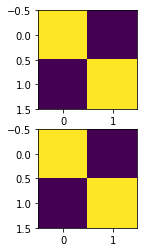

In [5]:
nsims = 10
nunits = 3   # Number of units to subsample
#nunits = callhist.shape[3]

# Test data
# 2 stims, 3 units, 3 reps
callhist_test = np.empty((2,3,5,3))
callhist_test[0,0,:,0] = [1,2,3,4,5]
callhist_test[0,0,:,1] = [1,2.2,3,4,5.5]
callhist_test[0,0,:,2] = [0.8,2,3,4.2,5]

callhist_test[1,0,:,0] = np.flipud([1,2,3,4,5])
callhist_test[1,0,:,1] = np.flipud([1,2.2,3,4,5.5])
callhist_test[1,0,:,2] = np.flipud([0.8,2,3,4.2,5])

callhist_test[0,1,:,0] = callhist_test[0,0,:,0]+1
callhist_test[0,1,:,1] = callhist_test[0,0,:,1]+1.2    # If these are exactly 1, the cor_mat becomes artificially symmetric
callhist_test[0,1,:,2] = callhist_test[0,0,:,2]+1.1

callhist_test[1,1,:,0] = callhist_test[1,0,:,0]+1
callhist_test[1,1,:,1] = callhist_test[1,0,:,1]+1
callhist_test[1,1,:,2] = callhist_test[1,0,:,2]+1

callhist_test[0,2,:,0] = callhist_test[0,0,:,0]-1
callhist_test[0,2,:,1] = callhist_test[0,0,:,1]-1
callhist_test[0,2,:,2] = callhist_test[0,0,:,2]-1

callhist_test[1,2,:,0] = callhist_test[1,0,:,0]-1
callhist_test[1,2,:,1] = callhist_test[1,0,:,1]-1
callhist_test[1,2,:,2] = callhist_test[1,0,:,2]-1

sim_decode(callhist_test,nsims,nunits)


(20, 10, 68, 54)
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  1  6  7  8  9 10 11 12 13 14 15 16  1 18 19]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_actual: [ 0  1  2  3  4  5  6  7  

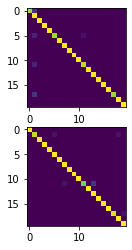

In [6]:
callhist_bu = callhist_all[:,:,:, (callhist_type_all == 'Burster_h') | (callhist_type_all == 'Burster_l')]

print(callhist_bu.shape)    

nsims = 20
nunits = 54

output = sim_decode(callhist_bu,nsims,nunits)
    
accu54_bu_mcc = output[0]['mcc']
accu54_bu_lda = output[0]['lda']
conf54_bu_mcc = output[1]['mcc']
conf54_bu_lda = output[1]['lda']

(20, 10, 68, 110)
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 1  1  2  3  1 17 17 17  8  9 10 11 17 13 14 15 16  1 18 19]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 5  1  2  9  4  1  6 17  8  9 10 11 11 13 14 15 16 17 18 19]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  5  5  5  5  0  8  9  5  5  5 12  5 15  6  9 18 19]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  3  5  4  5  7  8  8  9 10 11 12  5  4 15  6 17  3 19]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  2  4  5  6  1  8  9 10  3  3  3 14 11 17 17 18  2]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5 16  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_actual: [ 0  1  2  3  4  5  6  7 

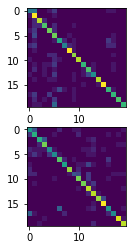

In [7]:
callhist_RS = callhist_all[:,:,:, (callhist_type_all == 'RS')]

print(callhist_RS.shape)    

nsims = 20
nunits = 54

output = sim_decode(callhist_RS,nsims,nunits)

accu54_RS_mcc = output[0]['mcc']
accu54_RS_lda = output[0]['lda']
conf54_RS_mcc = output[1]['mcc']
conf54_RS_lda = output[1]['lda']

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Accu: 0.6512562814070352
Accu: 0.903
Accu: 0.987


array([0.65125628, 0.903     , 0.987     ])

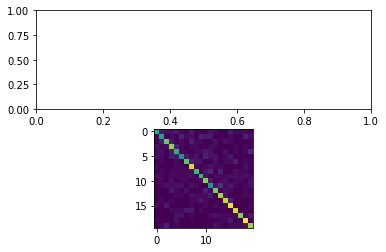

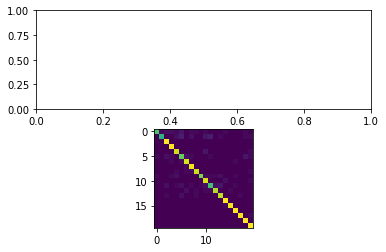

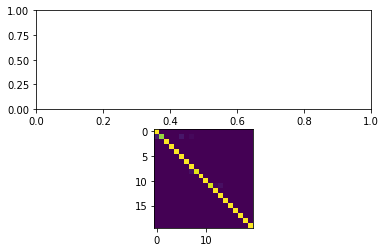

In [8]:
callhist_bu = callhist_all[:,:,:, (callhist_type_all == 'Burster_h') | (callhist_type_all == 'Burster_l')]
nsims = 50
nunits_list = [10, 25, 54]

accu_bu = np.empty(len(nunits_list))
accu_bu.fill(np.nan)

for i in range(len(nunits_list)):
    output = sim_decode(callhist_bu,nsims,nunits_list[i],LDA=False)
    accu_bu[i] = output[0]
accu_bu

Accu: 0.35
Accu: 0.5
Accu: 0.706
Accu: 0.831


array([0.35 , 0.5  , 0.706, 0.831])

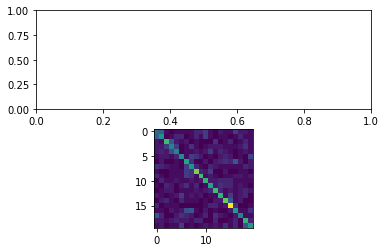

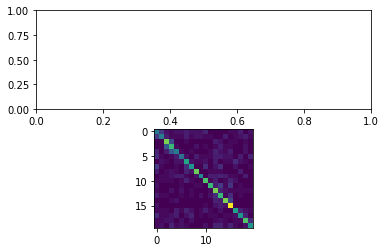

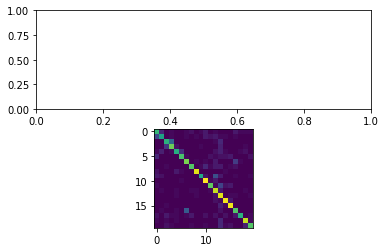

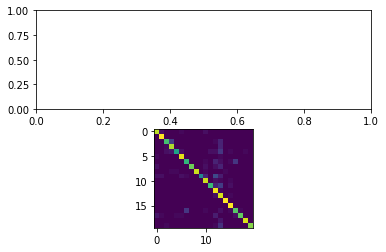

In [9]:
nunits_list = [10, 25, 54, 110]

accu_RS = np.empty(len(nunits_list))
accu_RS.fill(np.nan)

for i in range(len(nunits_list)):
    output = sim_decode(callhist_RS,nsims,nunits_list[i],LDA=False)
    accu_RS[i] = output[0]
accu_RS

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Accu: 0.4694694694694695
Accu: 0.692
Accu: 0.85
Accu: 0.973
Accu: 0.994


array([0.46946947, 0.692     , 0.85      , 0.973     , 0.994     ])

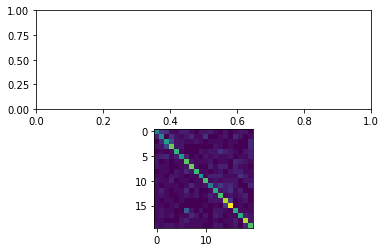

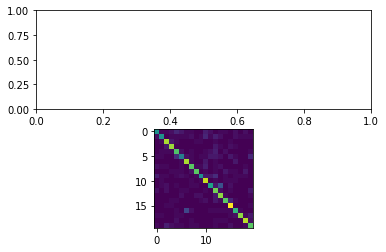

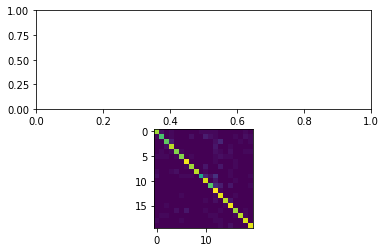

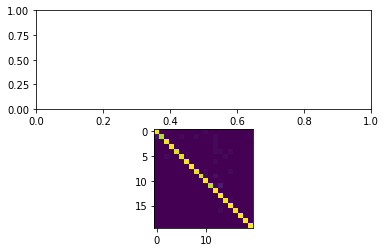

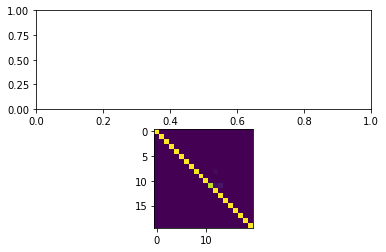

In [10]:
callhist_mixed = callhist_all[:,:,:, (callhist_type_all=='Burster_h') | (callhist_type_all=='Burster_l') | (callhist_type_all=='RS')]

nunits_list = [10, 25, 54, 110, 160]

accu_mixed = np.empty(len(nunits_list))
accu_mixed.fill(np.nan)

for i in range(len(nunits_list)):
    output = sim_decode(callhist_mixed,nsims,nunits_list[i],LDA=False)
    accu_mixed[i] = output[0]
accu_mixed

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Accu: 0.1991991991991992
Accu: 0.405
Accu: 0.639


array([0.1991992, 0.405    , 0.639    ])

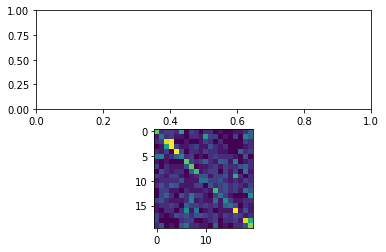

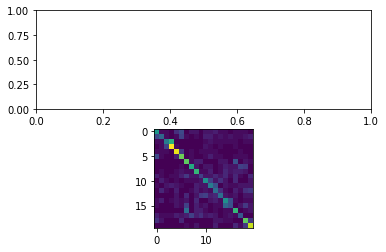

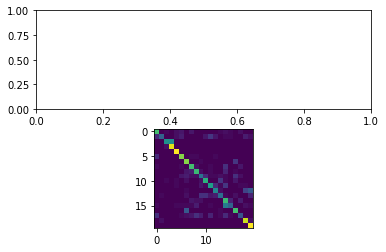

In [11]:
nsims = 50
nunits_list = [10, 25, 54]

accu_bu_t_collapse = np.empty(len(nunits_list))
accu_bu_t_collapse.fill(np.nan)

callhist_bu_t_collapse = np.expand_dims(np.mean(callhist_bu, 2),2)

for i in range(len(nunits_list)):
    output = sim_decode(callhist_bu_t_collapse,nsims,nunits_list[i],LDA=False)
    accu_bu_t_collapse[i] = output[0]
accu_bu_t_collapse

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Accu: 0.19617706237424548
Accu: 0.301
Accu: 0.414
Accu: 0.539


array([0.19617706, 0.301     , 0.414     , 0.539     ])

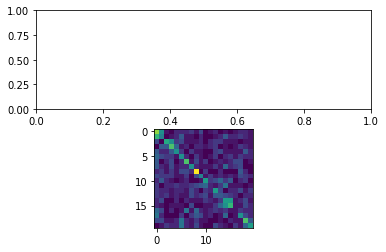

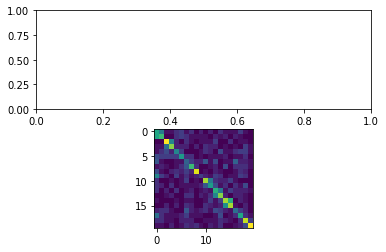

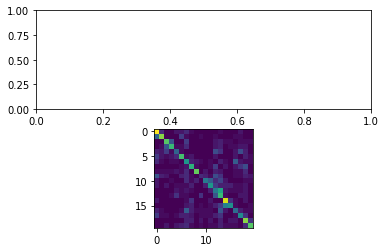

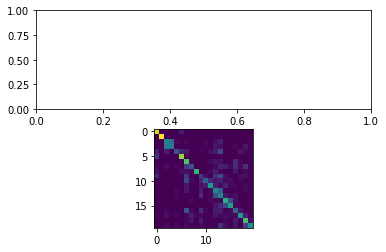

In [12]:
nsims = 50
nunits_list = [10, 25, 54, 110]

accu_RS_t_collapse = np.empty(len(nunits_list))
accu_RS_t_collapse.fill(np.nan)

callhist_RS_t_collapse = np.expand_dims(np.mean(callhist_RS, 2),2)

for i in range(len(nunits_list)):
    output = sim_decode(callhist_RS_t_collapse,nsims,nunits_list[i],LDA=False)
    accu_RS_t_collapse[i] = output[0]
accu_RS_t_collapse

Accu: 0.817


array([0.817])

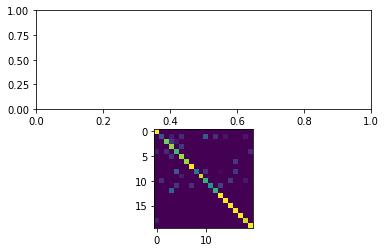

In [13]:
nsims = 50
nunits_list = [1]

accu_bu_unit_collapse = np.empty(len(nunits_list))
accu_bu_unit_collapse.fill(np.nan)

callhist_bu_unit_collapse = np.expand_dims(np.mean(callhist_bu, 3),3)

for i in range(len(nunits_list)):
    output = sim_decode(callhist_bu_unit_collapse,nsims,nunits_list[i],LDA=False)
    accu_bu_unit_collapse[i] = output[0]
accu_bu_unit_collapse

Accu: 0.437


array([0.437])

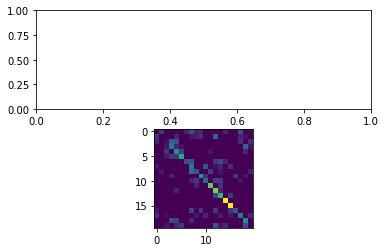

In [14]:
nsims = 50
nunits_list = [1]

accu_RS_unit_collapse = np.empty(len(nunits_list))
accu_RS_unit_collapse.fill(np.nan)

callhist_RS_unit_collapse = np.expand_dims(np.mean(callhist_RS, 3),3)

for i in range(len(nunits_list)):
    output = sim_decode(callhist_RS_unit_collapse,nsims,nunits_list[i],LDA=False)
    accu_RS_unit_collapse[i] = output[0]
accu_RS_unit_collapse

In [15]:
# Binned by 25 ms instead of 10 ms (temporal degradation)
callhist_all25ms = np.array([]).reshape(20,10,27,0)
callhist_type_all25ms = np.array([])

for i in range(len(animalID)):
    path = os.path.join(decode_dir, animalID[i]+'_batch','decode_25ms.mat')
    print(path)
    mat_dict = io.loadmat(path)
    #callhist[i] = mat_dict['callhist']
    callhist_all25ms = np.append(callhist_all25ms,mat_dict['callhist'],-1)
    callhist_type_all25ms = np.append(callhist_type_all25ms, mat_dict['callhist_type'])


M7E_batch/decode_25ms.mat
M117B_batch/decode_25ms.mat


Accu: 0.968


array([0.968])

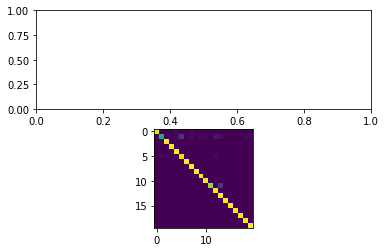

In [16]:
callhist_bu25ms = callhist_all25ms[:,:,:, (callhist_type_all25ms == 'Burster_h') | (callhist_type_all25ms == 'Burster_l')]
nsims = 50
nunits_list = [54]

accu_bu25ms = np.empty(len(nunits_list))
accu_bu25ms.fill(np.nan)

for i in range(len(nunits_list)):
    output = sim_decode(callhist_bu25ms,nsims,nunits_list[i],LDA=False)
    accu_bu25ms[i] = output[0]
accu_bu25ms

Accu: 0.718


array([0.718])

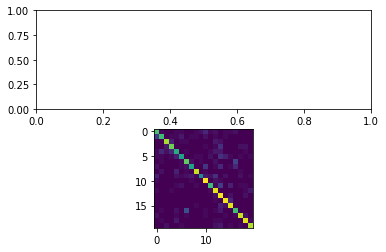

In [17]:
callhist_RS25ms = callhist_all25ms[:,:,:, (callhist_type_all25ms == 'RS')]

accu_RS25ms = np.empty(len(nunits_list))
accu_RS25ms.fill(np.nan)

for i in range(len(nunits_list)):
    output = sim_decode(callhist_RS25ms,nsims,nunits_list[i],LDA=False)
    accu_RS25ms[i] = output[0]
accu_RS25ms

In [18]:
# Binned by 50 ms instead of 10 ms (temporal degradation)
callhist_all50ms = np.array([]).reshape(20,10,13,0)
callhist_type_all50ms = np.array([])

for i in range(len(animalID)):
    path = os.path.join(decode_dir, animalID[i]+'_batch','decode_50ms.mat')
    print(path)
    mat_dict = io.loadmat(path)
    #callhist[i] = mat_dict['callhist']
    callhist_all50ms = np.append(callhist_all50ms,mat_dict['callhist'],-1)
    callhist_type_all50ms = np.append(callhist_type_all50ms, mat_dict['callhist_type'])


M7E_batch/decode_50ms.mat
M117B_batch/decode_50ms.mat


Accu: 0.959


array([0.959])

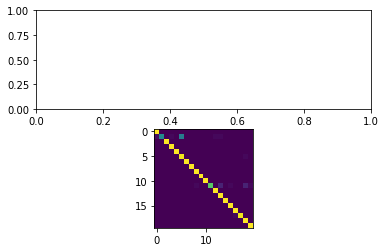

In [19]:
callhist_bu50ms = callhist_all50ms[:,:,:, (callhist_type_all50ms == 'Burster_h') | (callhist_type_all50ms == 'Burster_l')]
nsims = 50
nunits_list = [54]

accu_bu50ms = np.empty(len(nunits_list))
accu_bu50ms.fill(np.nan)

for i in range(len(nunits_list)):
    output = sim_decode(callhist_bu50ms,nsims,nunits_list[i],LDA=False)
    accu_bu50ms[i] = output[0]
accu_bu50ms

Accu: 0.685


array([0.685])

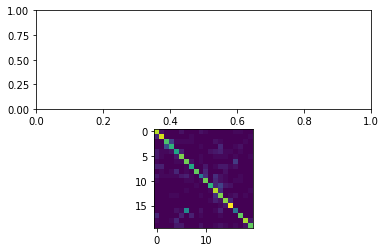

In [20]:
callhist_RS50ms = callhist_all50ms[:,:,:, (callhist_type_all50ms == 'RS')]

accu_RS50ms = np.empty(len(nunits_list))
accu_RS50ms.fill(np.nan)

for i in range(len(nunits_list)):
    output = sim_decode(callhist_RS50ms,nsims,nunits_list[i],LDA=False)
    accu_RS50ms[i] = output[0]
accu_RS50ms

In [22]:
# Binned by 5 ms instead of 10 ms (temporal degradation)
callhist_all5ms = np.array([]).reshape(20,10,136,0)
callhist_type_all5ms = np.array([])

for i in range(len(animalID)):
    path = os.path.join(decode_dir, animalID[i]+'_batch','decode_5ms.mat')
    print(path)
    mat_dict = io.loadmat(path)
    #callhist[i] = mat_dict['callhist']
    callhist_all5ms = np.append(callhist_all5ms,mat_dict['callhist'],-1)
    callhist_type_all5ms = np.append(callhist_type_all5ms, mat_dict['callhist_type'])


M7E_batch/decode_5ms.mat
M117B_batch/decode_5ms.mat


Accu: 0.981


array([0.981])

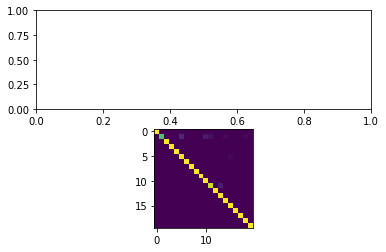

In [23]:
callhist_bu5ms = callhist_all5ms[:,:,:, (callhist_type_all5ms == 'Burster_h') | (callhist_type_all5ms == 'Burster_l')]
nsims = 50
nunits_list = [54]

accu_bu5ms = np.empty(len(nunits_list))
accu_bu5ms.fill(np.nan)

for i in range(len(nunits_list)):
    output = sim_decode(callhist_bu5ms,nsims,nunits_list[i],LDA=False)
    accu_bu5ms[i] = output[0]
accu_bu5ms

Accu: 0.621


array([0.621])

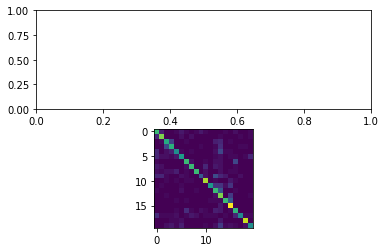

In [24]:
callhist_RS5ms = callhist_all5ms[:,:,:, (callhist_type_all5ms == 'RS')]

accu_RS5ms = np.empty(len(nunits_list))
accu_RS5ms.fill(np.nan)

for i in range(len(nunits_list)):
    output = sim_decode(callhist_RS5ms,nsims,nunits_list[i],LDA=False)
    accu_RS5ms[i] = output[0]
accu_RS5ms

In [25]:
path = os.path.join(decode_dir, 'decode_figdata.mat')
mdic = {"accu54_bu_mcc": accu54_bu_mcc,
        "accu54_bu_lda": accu54_bu_lda,
        "conf54_bu_mcc": conf54_bu_mcc,
        "conf54_bu_lda": conf54_bu_lda, 
        "accu54_RS_mcc": accu54_RS_mcc,
        "accu54_RS_lda": accu54_RS_lda,
        "conf54_RS_mcc": conf54_RS_mcc,
        "conf54_RS_lda": conf54_RS_lda,
        "accu_bu": accu_bu,
        "accu_RS": accu_RS,
        "accu_mixed": accu_mixed,
        "accu_bu_t_collapse": accu_bu_t_collapse,
        "accu_RS_t_collapse": accu_RS_t_collapse,
        "accu_bu_unit_collapse": accu_bu_unit_collapse,
        "accu_RS_unit_collapse": accu_RS_unit_collapse,
        "accu_bu25ms": accu_bu25ms,
        "accu_RS25ms": accu_RS25ms,
        "accu_bu50ms": accu_bu50ms, 
        "accu_RS50ms": accu_RS50ms,
        "accu_bu5ms": accu_bu5ms, 
        "accu_RS5ms": accu_RS5ms,   
       }
io.savemat(path,mdic)